In [13]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import rasterio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import splprep, splev, Rbf
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import cKDTree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import TruncatedSVD
%pip install torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.animation as animation
from matplotlib.patches import Circle
from scipy.interpolate import splprep, splev


Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("../data/df_illgraben_anomaly_scores.parquet", engine='fastparquet')
# --- Read coordinates ---
coords = pd.read_csv(
    "../data/coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [3]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [4]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [5]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [6]:
# Round time to nearest minute
df_merged['time_minute'] = df_merged['time'].dt.round('1min')

# Aggregate by station and minute
df_minute = (df_merged
             .groupby(['station', 'time_minute'])
             .agg({
                 'anomaly_score': 'mean',
                 'debris flow': 'max',  # If any reading in that minute has debris flow
                 'X_mn95': 'first',
                 'Y_mn95': 'first',
                 'Elevation': 'first'
             })
             .reset_index())

print(f"  Original readings: {len(df_merged):,}")
print(f"  After 1-min aggregation: {len(df_minute):,}")
print(f"  Time range: {df_minute['time_minute'].min()} to {df_minute['time_minute'].max()}")


  Original readings: 8,274,482
  After 1-min aggregation: 6,896,017
  Time range: 2018-05-14 11:03:00 to 2022-08-28 21:22:00


In [7]:
# Filter to June 2020
df_june = df_minute[
    (df_minute['time_minute'] >= '2020-06-01') & 
    (df_minute['time_minute'] < '2020-07-01')
].copy()

# Drop ILL14 and ILL15
df_june = df_june[~df_june['station'].isin(['ILL14', 'ILL15'])]

print(f"  June 2020 data points: {len(df_june):,}")
print(f"  Stations: {sorted(df_june['station'].unique())}")

  June 2020 data points: 259,075
  Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']


In [8]:
# Get unique station coordinates
station_coords = (df_june.groupby('station')
                  .agg({
                      'X_mn95': 'first',
                      'Y_mn95': 'first',
                      'Elevation': 'first'
                  })
                  .reset_index())

print(f"  Stations: {list(station_coords['station'])}")
print(f"  Elevation range: {station_coords['Elevation'].min():.1f}m to {station_coords['Elevation'].max():.1f}m")

# Create channel centerline
def create_channel_points_simple(station_coords, spacing=25):
    """Create interpolated points along channel."""
    # Sort stations by elevation (top to bottom)
    stations_sorted = station_coords.sort_values('Elevation', ascending=False).reset_index(drop=True)
    
    # Interpolate with spline
    tck, u = splprep(
        [stations_sorted['X_mn95'].values, 
         stations_sorted['Y_mn95'].values, 
         stations_sorted['Elevation'].values],
        s=0,
        k=min(3, len(stations_sorted)-1)
    )
    
    # Calculate path length
    u_samples = np.linspace(0, 1, 100)
    x_samples, y_samples, z_samples = splev(u_samples, tck)
    path_length = np.sum(np.sqrt(
        np.diff(x_samples)**2 + np.diff(y_samples)**2 + np.diff(z_samples)**2
    ))
    
    # Sample at specified spacing
    n_points = max(int(path_length / spacing), len(stations_sorted))
    u_fine = np.linspace(0, 1, n_points)
    X_channel, Y_channel, Z_channel = splev(u_fine, tck)
    
    # Calculate distances along channel
    distances = np.zeros(n_points)
    for i in range(1, n_points):
        distances[i] = distances[i-1] + np.sqrt(
            (X_channel[i] - X_channel[i-1])**2 + 
            (Y_channel[i] - Y_channel[i-1])**2 +
            (Z_channel[i] - Z_channel[i-1])**2
        )
    
    return pd.DataFrame({
        'point_id': range(n_points),
        'X': X_channel,
        'Y': Y_channel,
        'Z': Z_channel,
        'distance_from_top': distances
    })

# Create channel points
channel_points = create_channel_points_simple(station_coords, spacing=25)
print(f"  Created {len(channel_points)} channel points")
print(f"  Channel length: {channel_points['distance_from_top'].max():.0f}m")

# Map stations to distance along channel
station_to_distance = {}
for _, station_row in station_coords.iterrows():
    station = station_row['station']
    station_point = station_row[['X_mn95', 'Y_mn95']].values
    
    # Find nearest channel point
    distances_to_channel = np.sqrt(
        (channel_points['X'] - station_point[0])**2 +
        (channel_points['Y'] - station_point[1])**2
    )
    nearest_idx = distances_to_channel.argmin()
    station_to_distance[station] = channel_points.loc[nearest_idx, 'distance_from_top']

station_coords['distance_from_top'] = station_coords['station'].map(station_to_distance)
station_coords = station_coords.sort_values('distance_from_top')

print("\n  Station distances from top:")
for _, row in station_coords.iterrows():
    print(f"    {row['station']}: {row['distance_from_top']:.0f}m")

  Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']
  Elevation range: 665.2m to 2041.6m
  Created 267 channel points
  Channel length: 6694m

  Station distances from top:
    ILL16: 0m
    ILL17: 837m
    ILL18: 2502m
    ILL12: 4274m
    ILL13: 5390m
    ILL11: 6694m


In [9]:
# Pivot to wide format
df_wide = df_june.pivot(
    index='time_minute',
    columns='station',
    values='anomaly_score'
)

# Ensure column order matches station_coords
df_wide = df_wide[station_coords['station'].tolist()]

# Fill missing values
df_wide_filled = df_wide.fillna(method='ffill').fillna(method='bfill')

print(f"  Wide data shape: {df_wide_filled.shape}")
print(f"  Columns: {list(df_wide_filled.columns)}")

# Get debris flow ground truth
debris_flow = df_june.groupby('time_minute')['debris flow'].max()
debris_flow = debris_flow.reindex(df_wide_filled.index).fillna(0).astype(int)

print(f"  Debris flow timepoints: {debris_flow.sum()} / {len(debris_flow)}")

  Wide data shape: (43200, 6)
  Columns: ['ILL16', 'ILL17', 'ILL18', 'ILL12', 'ILL13', 'ILL11']
  Debris flow timepoints: 868 / 43200


In [10]:
lag_start = 120  # Look back 120 minutes
lag_end = 10     # Up to 10 minutes ago (prediction point)

print(f"  Temporal window: [t-{lag_start}, t-{lag_end}]")
print(f"  Creating statistical features per station...")

def create_features(df_wide, lag_start, lag_end):
    """Create statistical features over temporal window."""
    features_list = []
    valid_indices = []
    
    for i in range(lag_start, len(df_wide)):
        # Get window [t-lag_start to t-lag_end]
        window_start = i - lag_start
        window_end = i - lag_end
        window = df_wide.iloc[window_start:window_end]
        
        if len(window) < (lag_start - lag_end):
            continue
        
        # Compute features for each station
        row_features = []
        for station in df_wide.columns:
            scores = window[station].values
            
            # Statistical features
            max_score = scores.max()
            mean_score = scores.mean()
            std_score = scores.std()
            
            # Trend (linear slope)
            x = np.arange(len(scores))
            trend = np.polyfit(x, scores, 1)[0] if len(scores) > 1 else 0
            
            # Recent spike (max in last 30 vs rest)
            if len(scores) >= 60:
                recent_max = scores[-30:].max()
                earlier_max = scores[:-30].max()
                spike = recent_max - earlier_max
            else:
                spike = 0
            
            row_features.extend([max_score, mean_score, std_score, trend, spike])
        
        features_list.append(row_features)
        valid_indices.append(i)
    
    # Create feature names
    feature_names = []
    for station in df_wide.columns:
        feature_names.extend([
            f'{station}_max',
            f'{station}_mean',
            f'{station}_std',
            f'{station}_trend',
            f'{station}_spike'
        ])
    
    features_df = pd.DataFrame(features_list, columns=feature_names)
    features_df.index = df_wide.index[valid_indices]
    
    return features_df

features_df = create_features(df_wide_filled, lag_start, lag_end)

print(f"  Features shape: {features_df.shape}")
print(f"  Feature columns: {len(features_df.columns)} (6 stations × 5 statistics)")

# Align targets with features
targets = debris_flow.loc[features_df.index]

print(f"  Final dataset size: {len(features_df)}")
print(f"  Positive class (debris flow): {targets.sum()} ({100*targets.mean():.1f}%)")

  Temporal window: [t-120, t-10]
  Creating statistical features per station...
  Features shape: (43080, 30)
  Feature columns: 30 (6 stations × 5 statistics)
  Final dataset size: 43080
  Positive class (debris flow): 868 (2.0%)


In [11]:
split_idx = int(len(features_df) * 0.8)
split_time = features_df.index[split_idx]

X_train = features_df.iloc[:split_idx]
y_train = targets.iloc[:split_idx]

X_test = features_df.iloc[split_idx:]
y_test = targets.iloc[split_idx:]

print(f"  Split time: {split_time}")
print(f"  Training samples: {len(X_train)} (debris flow: {y_train.sum()})")
print(f"  Test samples: {len(X_test)} (debris flow: {y_test.sum()})")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

  Split time: 2020-06-25 00:24:00
  Training samples: 34464 (debris flow: 765)
  Test samples: 8616 (debris flow: 103)


In [14]:
# Handle class imbalance with class weights
class_weights = {
    0: 1.0,
    1: len(y_train) / (2 * y_train.sum())  # Weight for minority class
}

print(f"  Class weights: {class_weights}")

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

print("  ✓ Training complete")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features_df.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n  Top 10 most important features:")
print(feature_importance.head(10).to_string(index=False))


  Class weights: {0: 1.0, 1: np.float64(22.525490196078433)}
  ✓ Training complete

  Top 10 most important features:
    feature  importance
  ILL18_max    0.164504
  ILL13_max    0.095756
 ILL18_mean    0.085161
  ILL12_max    0.077971
  ILL18_std    0.073414
  ILL12_std    0.073315
 ILL16_mean    0.063236
 ILL12_mean    0.056211
ILL18_trend    0.054668
  ILL16_std    0.039400


In [15]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("TRAINING SET PERFORMANCE")

print(classification_report(y_train, y_train_pred, target_names=['No Flow', 'Debris Flow']))

print("TEST SET PERFORMANCE")
print(classification_report(y_test, y_test_pred, target_names=['No Flow', 'Debris Flow']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Test Set):")
print(f"                Predicted No Flow  Predicted Debris Flow")
print(f"Actual No Flow        {cm[0,0]:5d}              {cm[0,1]:5d}")
print(f"Actual Debris Flow    {cm[1,0]:5d}              {cm[1,1]:5d}")

# F1, Precision, Recall
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f"\nTest Set Metrics:")
print(f"  F1 Score:  {f1:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")

TRAINING SET PERFORMANCE
              precision    recall  f1-score   support

     No Flow       1.00      1.00      1.00     33699
 Debris Flow       0.96      1.00      0.98       765

    accuracy                           1.00     34464
   macro avg       0.98      1.00      0.99     34464
weighted avg       1.00      1.00      1.00     34464

TEST SET PERFORMANCE
              precision    recall  f1-score   support

     No Flow       1.00      1.00      1.00      8513
 Debris Flow       0.75      0.74      0.74       103

    accuracy                           0.99      8616
   macro avg       0.87      0.87      0.87      8616
weighted avg       0.99      0.99      0.99      8616


Confusion Matrix (Test Set):
                Predicted No Flow  Predicted Debris Flow
Actual No Flow         8487                 26
Actual Debris Flow       27                 76

Test Set Metrics:
  F1 Score:  0.7415
  Precision: 0.7451
  Recall:    0.7379


In [16]:
def estimate_flow_head(time_idx, df_wide, lag_end=10):
    """Estimate flow head location at time t using scores at t-10."""
    # Get anomaly scores at t-10
    prediction_time_idx = time_idx - lag_end
    
    if prediction_time_idx < 0:
        return None, None, None
    
    scores = df_wide.iloc[prediction_time_idx]
    max_station = scores.idxmax()
    max_score = scores.max()
    
    # Get station location
    station_info = station_coords[station_coords['station'] == max_station].iloc[0]
    
    return max_station, max_score, station_info['distance_from_top']

# Create tracking dataframe for test period
tracking_results = []

for i, time in enumerate(X_test.index):
    # Get prediction
    actual = y_test.iloc[i]
    predicted = y_test_pred[i]
    
    # Estimate head location (using actual debris flow times for visualization)
    if actual == 1:  # Only track when debris flow is actually present
        time_idx = df_wide_filled.index.get_loc(time)
        head_station, head_score, head_distance = estimate_flow_head(time_idx, df_wide_filled, lag_end)
        
        tracking_results.append({
            'time': time,
            'actual_debris_flow': actual,
            'predicted_debris_flow': predicted,
            'head_station': head_station,
            'head_score': head_score,
            'head_distance_from_top': head_distance
        })

tracking_df = pd.DataFrame(tracking_results)

print(f"  Tracked {len(tracking_df)} timepoints during actual debris flows")
if len(tracking_df) > 0:
    print(f"  Classifier detected {tracking_df['predicted_debris_flow'].sum()} / {len(tracking_df)} correctly")
    print(f"\n  Flow head station distribution:")
    print(tracking_df['head_station'].value_counts())

  Tracked 103 timepoints during actual debris flows
  Classifier detected 76 / 103 correctly

  Flow head station distribution:
head_station
ILL18    34
ILL11    29
ILL12    20
ILL13    15
ILL17     5
Name: count, dtype: int64


  Saved: debris_flow_station_map.png


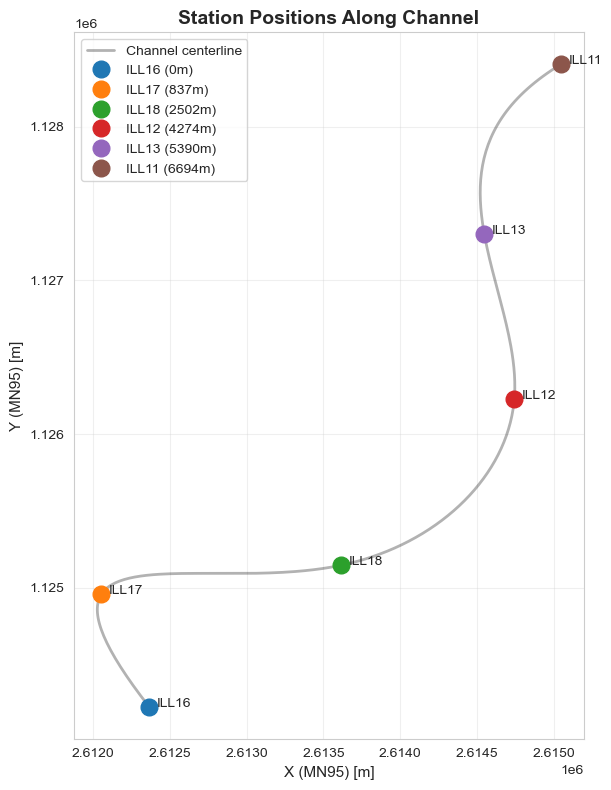

  Saved: debris_flow_head_progression.png


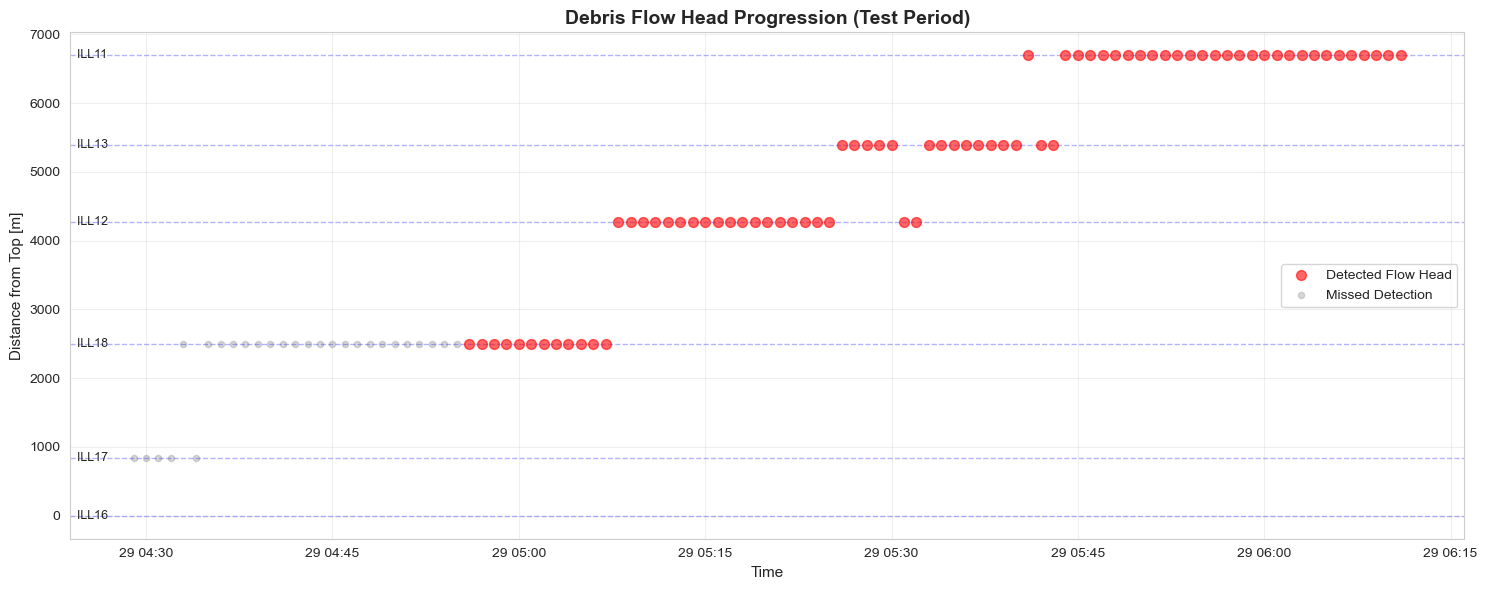

In [17]:
# Plot 1: Station positions along channel
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot channel centerline
ax.plot(channel_points['X'], channel_points['Y'], 'k-', linewidth=2, alpha=0.3, label='Channel centerline')

# Plot stations
for _, row in station_coords.iterrows():
    ax.plot(row['X_mn95'], row['Y_mn95'], 'o', markersize=12, 
            label=f"{row['station']} ({row['distance_from_top']:.0f}m)")
    ax.text(row['X_mn95'] + 50, row['Y_mn95'], row['station'], fontsize=10)

ax.set_xlabel('X (MN95) [m]', fontsize=11)
ax.set_ylabel('Y (MN95) [m]', fontsize=11)
ax.set_title('Station Positions Along Channel', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('debris_flow_station_map.png', dpi=300, bbox_inches='tight')
print("  Saved: debris_flow_station_map.png")
plt.show()

# Plot 2: Flow head progression over time (distance from top)
if len(tracking_df) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    # Plot detected flow head distance
    detected_mask = tracking_df['predicted_debris_flow'] == 1
    ax.scatter(tracking_df[detected_mask]['time'], 
              tracking_df[detected_mask]['head_distance_from_top'],
              c='red', s=50, alpha=0.6, label='Detected Flow Head', zorder=3)
    
    ax.scatter(tracking_df[~detected_mask]['time'], 
              tracking_df[~detected_mask]['head_distance_from_top'],
              c='gray', s=20, alpha=0.3, label='Missed Detection', zorder=2)
    
    # Add station reference lines
    for _, row in station_coords.iterrows():
        ax.axhline(row['distance_from_top'], color='blue', linestyle='--', 
                   alpha=0.3, linewidth=1)
        ax.text(ax.get_xlim()[0], row['distance_from_top'], 
                f"  {row['station']}", fontsize=9, va='center')
    
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Distance from Top [m]', fontsize=11)
    ax.set_title('Debris Flow Head Progression (Test Period)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('debris_flow_head_progression.png', dpi=300, bbox_inches='tight')
    print("  Saved: debris_flow_head_progression.png")
    plt.show()

  Creating animation with 76 frames...
  Saving animation (this may take a minute)...


MovieWriter ffmpeg unavailable; using Pillow instead.


  ✓ Saved: debris_flow_head_animation.gif
  ⚠ Could not save MP4 (ffmpeg not available): unknown file extension: .mp4


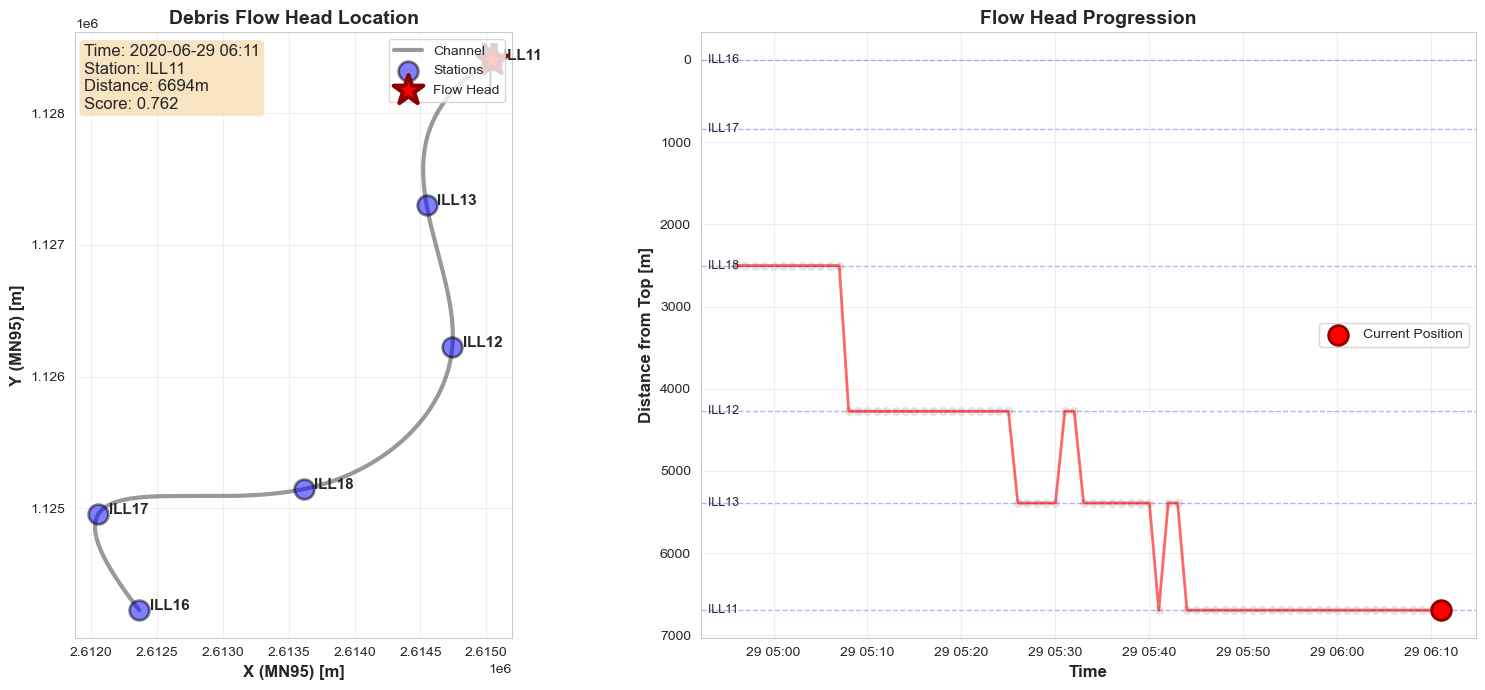


  Animation complete!
  Frames: 76
  Duration: ~15.2 seconds at 5 fps
  Saved: debris_flow_tracking_summary.png


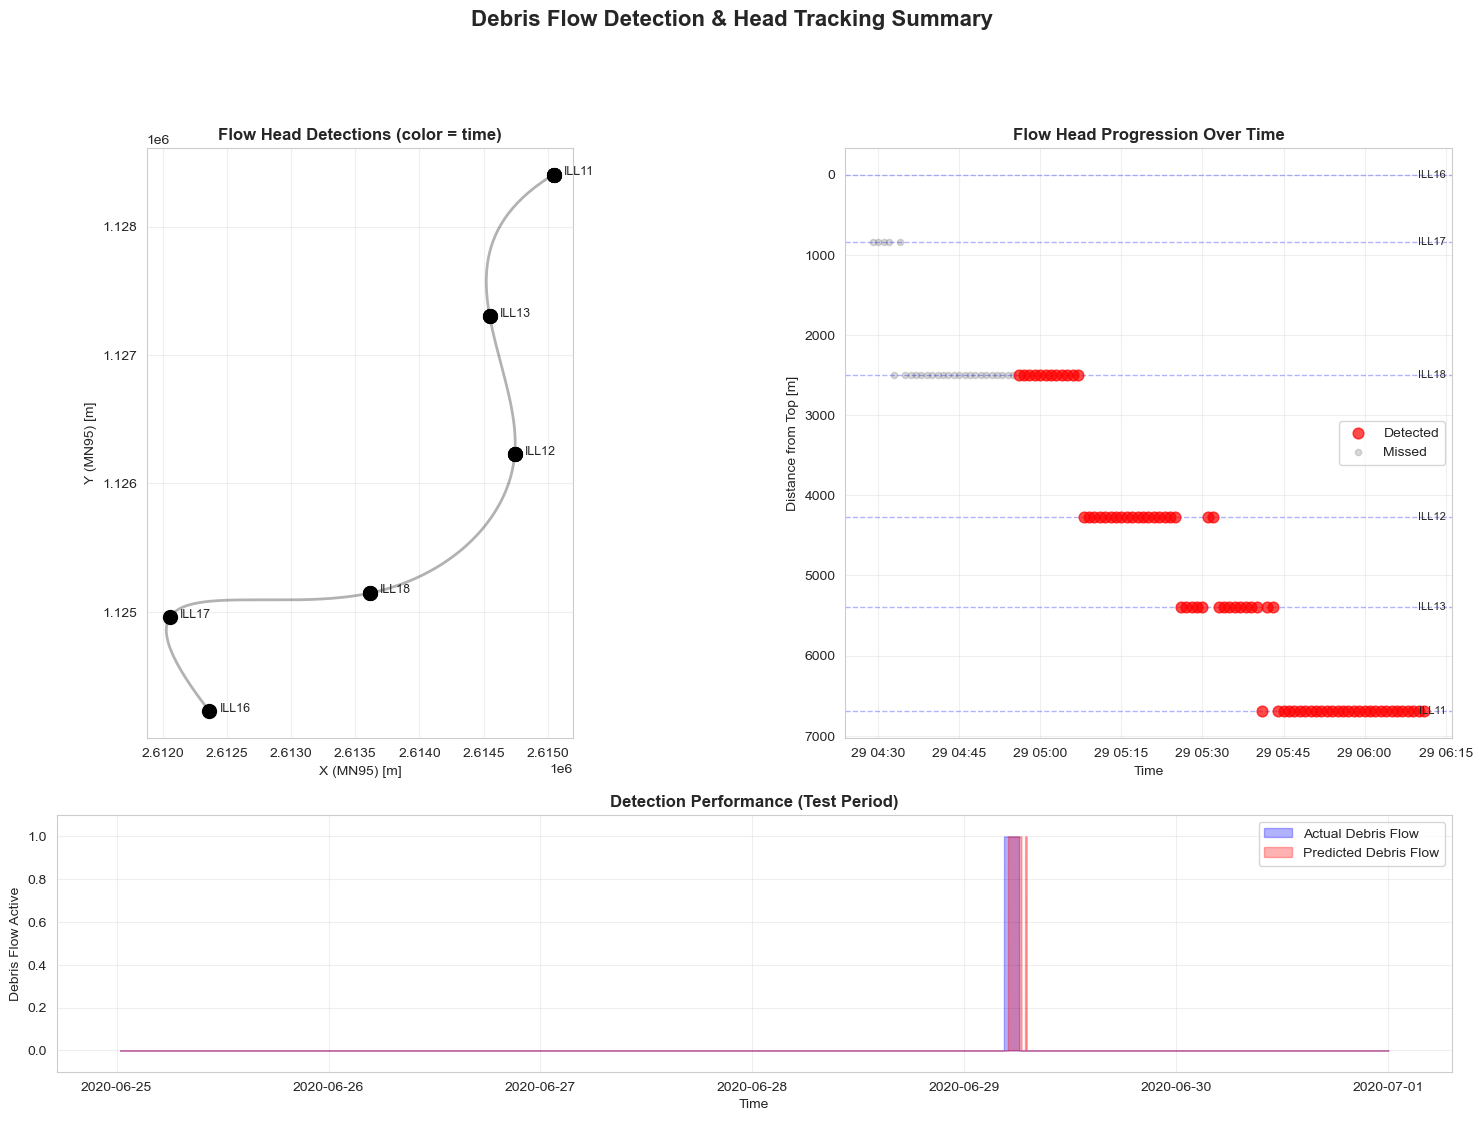

In [18]:
if len(tracking_df) > 0:
    # Filter to only detected debris flows for cleaner animation
    detected_df = tracking_df[tracking_df['predicted_debris_flow'] == 1].copy()
    
    if len(detected_df) > 0:
        print(f"  Creating animation with {len(detected_df)} frames...")
        
        # Set up the figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        # LEFT PANEL: Spatial map
        # Plot channel centerline
        ax1.plot(channel_points['X'], channel_points['Y'], 'k-', 
                linewidth=3, alpha=0.4, label='Channel', zorder=1)
        
        # Plot all stations
        station_scatter = ax1.scatter(
            station_coords['X_mn95'], 
            station_coords['Y_mn95'],
            s=200, c='blue', alpha=0.5, 
            edgecolors='black', linewidth=2,
            label='Stations', zorder=2
        )
        
        # Add station labels
        for _, row in station_coords.iterrows():
            ax1.text(row['X_mn95'] + 80, row['Y_mn95'], row['station'], 
                    fontsize=11, fontweight='bold')
        
        # Flow head marker (will be updated)
        flow_head = ax1.scatter([], [], s=500, c='red', marker='*', 
                               edgecolors='darkred', linewidth=3,
                               label='Flow Head', zorder=4)
        
        ax1.set_xlabel('X (MN95) [m]', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Y (MN95) [m]', fontsize=12, fontweight='bold')
        ax1.set_title('Debris Flow Head Location', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=10)
        ax1.grid(alpha=0.3)
        ax1.set_aspect('equal')
        
        # Add north arrow
        ax1.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction',
                    fontsize=20, fontweight='bold', ha='center')
        ax1.annotate('↑', xy=(0.95, 0.92), xycoords='axes fraction',
                    fontsize=30, ha='center')
        
        # Time text
        time_text = ax1.text(0.02, 0.98, '', transform=ax1.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # RIGHT PANEL: Distance-time plot
        # Plot all detected points in gray first
        ax2.scatter(detected_df['time'], detected_df['head_distance_from_top'],
                   c='lightgray', s=30, alpha=0.5, zorder=1)
        
        # Add station reference lines
        for _, row in station_coords.iterrows():
            ax2.axhline(row['distance_from_top'], color='blue', 
                       linestyle='--', alpha=0.3, linewidth=1)
            ax2.text(ax2.get_xlim()[0], row['distance_from_top'], 
                    f"  {row['station']}", fontsize=9, va='center')
        
        # Current position marker (will be updated)
        current_pos = ax2.scatter([], [], s=200, c='red', marker='o',
                                 edgecolors='darkred', linewidth=2,
                                 zorder=3, label='Current Position')
        
        # Trail (will be updated)
        trail_line, = ax2.plot([], [], 'r-', linewidth=2, alpha=0.6, zorder=2)
        
        ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Distance from Top [m]', fontsize=12, fontweight='bold')
        ax2.set_title('Flow Head Progression', fontsize=14, fontweight='bold')
        ax2.legend(loc='best', fontsize=10)
        ax2.grid(alpha=0.3)
        ax2.invert_yaxis()  # Top of channel at top of plot
        
        plt.tight_layout()
        
        # Animation function
        def animate(frame):
            # Get data for this frame
            row = detected_df.iloc[frame]
            
            # Get station coordinates
            station_info = station_coords[station_coords['station'] == row['head_station']].iloc[0]
            
            # Update flow head position on map
            flow_head.set_offsets([[station_info['X_mn95'], station_info['Y_mn95']]])
            
            # Update time text
            time_text.set_text(f"Time: {row['time'].strftime('%Y-%m-%d %H:%M')}\n"
                              f"Station: {row['head_station']}\n"
                              f"Distance: {row['head_distance_from_top']:.0f}m\n"
                              f"Score: {row['head_score']:.3f}")
            
            # Update current position on distance-time plot
            current_pos.set_offsets([[row['time'], row['head_distance_from_top']]])
            
            # Update trail (show path up to current frame)
            trail_data = detected_df.iloc[:frame+1]
            trail_line.set_data(trail_data['time'], trail_data['head_distance_from_top'])
            
            return flow_head, time_text, current_pos, trail_line
        
        # Create animation
        anim = animation.FuncAnimation(
            fig, animate, frames=len(detected_df),
            interval=200,  # 200ms between frames
            blit=True, repeat=True
        )
        
        # Save animation
        print("  Saving animation (this may take a minute)...")
        anim.save('debris_flow_head_animation.gif', writer='pillow', fps=5, dpi=100)
        print("  ✓ Saved: debris_flow_head_animation.gif")
        
        # Also save as MP4 if ffmpeg is available
        try:
            anim.save('debris_flow_head_animation.mp4', writer='ffmpeg', fps=5, dpi=150)
            print("  ✓ Saved: debris_flow_head_animation.mp4")
        except Exception as e:
            print(f"  ⚠ Could not save MP4 (ffmpeg not available): {e}")
        
        plt.show()
        
        print(f"\n  Animation complete!")
        print(f"  Frames: {len(detected_df)}")
        print(f"  Duration: ~{len(detected_df)/5:.1f} seconds at 5 fps")
    else:
        print("  ⚠ No detected debris flows in test set - cannot create animation")
else:
    print("  ⚠ No tracking data available - cannot create animation")


if len(tracking_df) > 0:
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Panel 1: Spatial map with all flow head detections
    ax1 = fig.add_subplot(gs[0:2, 0])
    ax1.plot(channel_points['X'], channel_points['Y'], 'k-', 
            linewidth=2, alpha=0.3, label='Channel')
    
    # Color code by time
    detected = tracking_df[tracking_df['predicted_debris_flow'] == 1]
    if len(detected) > 0:
        # Get coordinates for each detection
        for _, row in detected.iterrows():
            station_info = station_coords[station_coords['station'] == row['head_station']].iloc[0]
            time_fraction = (row['time'] - detected['time'].min()) / (detected['time'].max() - detected['time'].min())
            ax1.scatter(station_info['X_mn95'], station_info['Y_mn95'], 
                       s=100, c=[time_fraction], cmap='hot', alpha=0.6,
                       vmin=0, vmax=1, edgecolors='black', linewidth=0.5)
    
    # Plot stations
    for _, row in station_coords.iterrows():
        ax1.plot(row['X_mn95'], row['Y_mn95'], 'ko', markersize=10)
        ax1.text(row['X_mn95'] + 80, row['Y_mn95'], row['station'], fontsize=9)
    
    ax1.set_xlabel('X (MN95) [m]')
    ax1.set_ylabel('Y (MN95) [m]')
    ax1.set_title('Flow Head Detections (color = time)', fontweight='bold')
    ax1.set_aspect('equal')
    ax1.grid(alpha=0.3)
    
    # Panel 2: Distance-time progression
    ax2 = fig.add_subplot(gs[0:2, 1])
    detected_mask = tracking_df['predicted_debris_flow'] == 1
    ax2.scatter(tracking_df[detected_mask]['time'], 
               tracking_df[detected_mask]['head_distance_from_top'],
               c='red', s=60, alpha=0.7, label='Detected', zorder=3)
    ax2.scatter(tracking_df[~detected_mask]['time'], 
               tracking_df[~detected_mask]['head_distance_from_top'],
               c='gray', s=20, alpha=0.3, label='Missed', zorder=2)
    
    for _, row in station_coords.iterrows():
        ax2.axhline(row['distance_from_top'], color='blue', 
                   linestyle='--', alpha=0.3, linewidth=1)
        ax2.text(ax2.get_xlim()[1], row['distance_from_top'], 
                f"{row['station']}  ", fontsize=8, va='center', ha='right')
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Distance from Top [m]')
    ax2.set_title('Flow Head Progression Over Time', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.invert_yaxis()
    
    # Panel 3: Detection performance over time
    ax3 = fig.add_subplot(gs[2, :])
    
    # Plot actual vs predicted
    test_times = X_test.index
    ax3.fill_between(test_times, 0, y_test.values, 
                     alpha=0.3, color='blue', label='Actual Debris Flow')
    ax3.fill_between(test_times, 0, y_test_pred, 
                     alpha=0.3, color='red', label='Predicted Debris Flow')
    
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Debris Flow Active')
    ax3.set_title('Detection Performance (Test Period)', fontweight='bold')
    ax3.set_ylim([-0.1, 1.1])
    ax3.legend(loc='upper right')
    ax3.grid(alpha=0.3)
    
    plt.suptitle('Debris Flow Detection & Head Tracking Summary', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('debris_flow_tracking_summary.png', dpi=300, bbox_inches='tight')
    print("  Saved: debris_flow_tracking_summary.png")
    plt.show()
